# Detrended binned WLCs

## Setup

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import glob as glob
import matplotlib as mpl
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import seaborn as sns

import corner
import json
import pathlib
import pickle
import utils
import warnings

from astropy import constants as const
from astropy import units as uni
from astropy.io import ascii, fits
from astropy.time import Time
from mpl_toolkits.axes_grid1 import ImageGrid

# Default figure dimensions
FIG_WIDE = (11, 5)
FIG_LARGE = (8, 11)

# Figure style
sns.set(style="ticks", palette="colorblind", color_codes=True, context="talk")
params = utils.plot_params()
plt.rcParams.update(params)

<IPython.core.display.Javascript object>

## [Dowload data](https://www.dropbox.com/sh/h98hfodz6sgn3q9/AADdRUyri4ZwajiEPqDoGQfqa?dl=1)

Unzip this into a folder named `data` in the same level as this notebook

## Plot

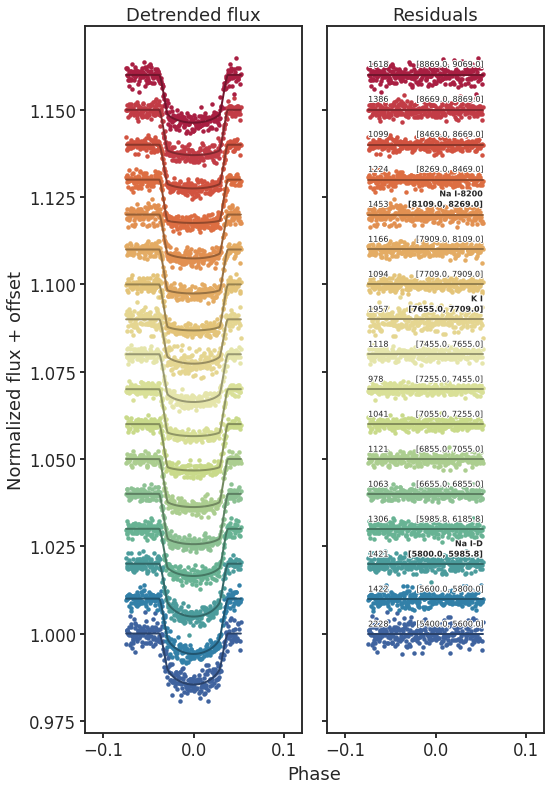

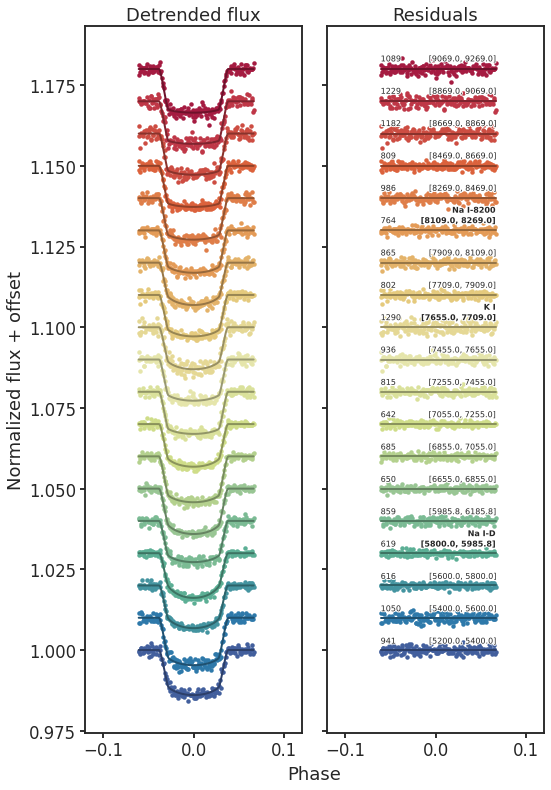

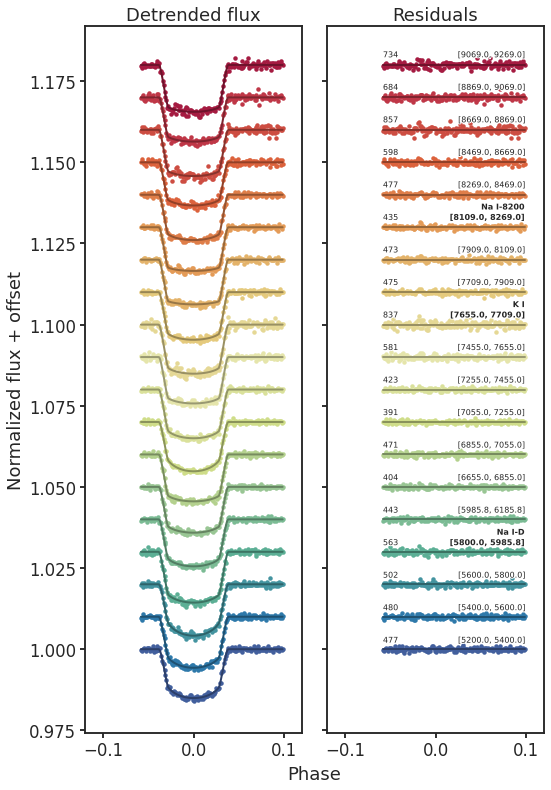

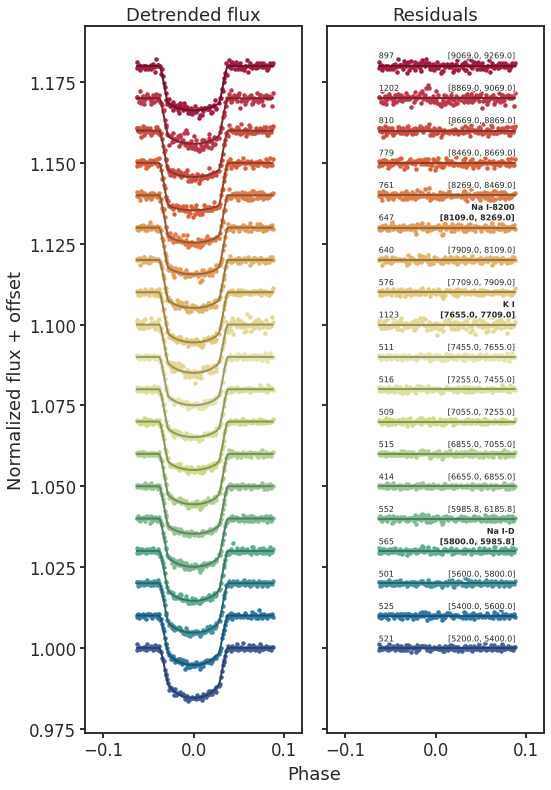

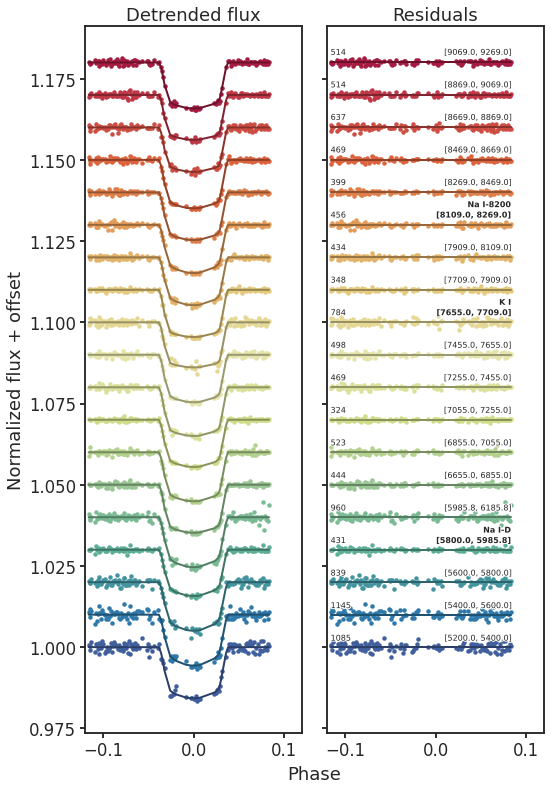

<IPython.core.display.Javascript object>

In [5]:
data_dir = "data/detrended_binned_lcs"
dirpaths = sorted(glob.glob(f"{data_dir}/hp*"))
dirpath_dict = {
    f"Transit {i}": dirpath for (i, dirpath) in enumerate(dirpaths, start=1)
}

for title, GPT_dir in dirpath_dict.items():
    wbin_paths = sorted(glob.glob(f"{GPT_dir}/wavelength/wbin*"), key=utils.wbin_num)
    PCA_list = []
    for wbin_path in wbin_paths:
        PCA_paths = glob.glob(f"{wbin_path}/PCA*")
        PCAs = [path.split("/")[-1] for path in PCA_paths]
        PCA_list.append(PCAs)

    common_PCAs = set(PCA_list[0])
    for s in PCA_list[1:]:
        common_PCAs.intersection_update(s)

    PCA_max = max(common_PCAs, key=lambda s: int(s.split("_")[-1]))
    PCA_num = int(PCA_max.split("_")[-1])
    # print(f"max common PCA = {PCA_num}")

    # Getting t0 from WLC data
    fpath = f"{GPT_dir}/white-light/results.dat"
    t0 = float(utils.get_result(fpath, key="t0", unc=False))
    P = float(utils.get_result(fpath, key="P", unc=False))

    # Get wavelength bins
    fpath = f"{GPT_dir}/transpec.csv"
    wbins = np.loadtxt(fpath, skiprows=1, usecols=[0, 1], delimiter=",")

    # Glob doesn't automatically sort, but instead follows the local filesystem"s
    # rules, which can be very system dependent.
    # To avoid potential cross-platform issues, I just sort based on an explicit
    # rule that is passed to `sorted`. In this case, the rule is:
    # sort based on the <num> part in wbin<num> of each file path.
    dirpath = f"{GPT_dir}/wavelength"
    detrended_files = f"{dirpath}/wbin*/PCA_{PCA_num}/detrended_lc.dat"
    fpaths = sorted(glob.glob(detrended_files), key=utils.wbin_num)

    # Store final data in <# of wavelength bins> x <length of timeseries> arrays
    detfluxes, models, resids = [], [], []
    for fpath in fpaths:
        time, detflux, detfluxerr, model = np.loadtxt(fpath, unpack=True)
        detfluxes.append(detflux)
        models.append(model)
        resids.append(detflux - model + 1)
    detfluxes = np.array(detfluxes).T
    models = np.array(models).T
    resids = np.array(resids).T
    phase = utils.get_phases(time, P, t0)
    time_rel = phase

    ###################################
    # Plot detrended flux and residuals
    ###################################
    # Plot configs
    N = detfluxes.shape[1]  # Number of wavelength bins
    colors = np.array(sns.color_palette("Spectral_r", N))

    offset = 0.01  # Spacing betweem binned lcs
    # Optional bins to highlight
    species = {
        "Na I-D": 5892.9,
        # "Hα":6564.6,
        "K I": 7682.0,
        "Na I-8200": 8189.0,
    }
    scatter_plot_kwargs = {
        "marker": ".",
        "lw": 0,
        "mew": 0,  # Make non-zero to show marker outlines
    }
    annotate_kwargs = {
        "fontsize": 8,
        "horizontalalignment": "right",
        "path_effects": [PathEffects.withStroke(linewidth=2, foreground="w")],
    }
    annotate_rms_kwargs = {
        "fontsize": 8,
        "horizontalalignment": "left",
        "path_effects": [PathEffects.withStroke(linewidth=2, foreground="w")],
    }

    fig, axes = plt.subplots(1, 2, figsize=(FIG_LARGE), sharex=True, sharey=True)
    ax_left, ax_right = axes.flatten()

    # Detrended flux
    ax_left.set_title("Detrended flux")
    p_det = utils.plot_binned(
        ax_left,
        time_rel,
        detfluxes,
        wbins,
        offset,
        colors,
        plot_kwargs=scatter_plot_kwargs,
        models=models,
    )

    # Residual flux
    ax_right.set_title("Residuals")
    baselines = np.ones_like(resids)
    p_res = utils.plot_binned(
        ax_right,
        time_rel,
        resids,
        wbins,
        offset,
        colors,
        plot_kwargs=scatter_plot_kwargs,
        models=baselines,
        annotate=True,
        annotate_kwargs=annotate_kwargs,
        annotate_rms_kwargs=annotate_rms_kwargs,
        species=species,
    )

    # Save
    ax_left.set_ylabel("Normalized flux + offset")
    fig.text(0.52, 0, "Phase", ha="left")
    ax_left.set_xlim(-0.12, 0.12)
    fig.tight_layout()
    fig.set_size_inches(FIG_LARGE)
    title = "detrended_binned_lcs_" + title.lower().replace(" ", "_")

    utils.savefig(f"../paper/figures/detrended_binned_lcs/{title}.pdf")